In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from IPython.core.pylabtools import figsize
from __future__ import print_function

import os
import sys
import glob
import time
import numpy as np
import numpy.random as nr

from keras.preprocessing.image import load_img, img_to_array, array_to_img

from keras.models import Model
from keras.applications import vgg19

from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b

np.set_printoptions(precision=3, linewidth=120, suppress=True)

Using TensorFlow backend.


In [2]:
sys.path.append('../src')
from my_keras_utilities import get_available_gpus
import keras.backend as K
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


Content image: (1, 400, 600, 3) -123.68 151.061
  Style image: (1, 400, 600, 3) -116.779 131.32


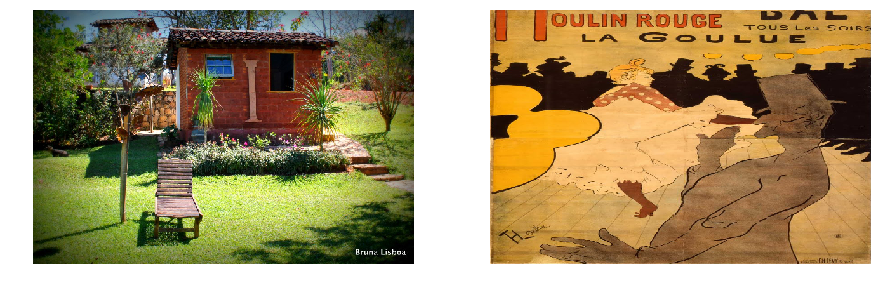

In [23]:
figdir = '../figures/style_transfer/'
resdir = figdir + 'results/'
os.makedirs(resdir, exist_ok=True)

image_file_path = figdir + 'museu_by_bruna.png'
image_file_path = figdir + 'lavras_novas__bruna.png'

style_file_path = figdir + 'tolouse-lautrec.png'

width, height = load_img(image_file_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(a):
    x = a.copy()
    x = x.reshape(img_nrows, img_ncols, 3)
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

vgg_image = preprocess_image(image_file_path)
vgg_style = preprocess_image(style_file_path)

print('Content image:', vgg_image.shape, vgg_image.min(), vgg_image.max())
print('  Style image:', vgg_style.shape, vgg_style.min(), vgg_style.max())

fig = plot.figure(figsize=(15, 7))
plot.subplot(1, 2, 1)
plot.imshow(deprocess_image(vgg_image[0]))
plot.axis('off')

plot.subplot(1, 2, 2)
plot.imshow(deprocess_image(vgg_style[0]))
plot.axis('off');


In [4]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def compute_style_loss(output, target): 
    """this "style loss" is designed to maintain
    the style of the reference image in the generated image.
    It is based on the gram matrices (which capture style) of
    feature maps from the style reference image
    and from the generated image"""
    assert K.ndim(output) == 3
    assert K.ndim(target) == 3
    x_gram = gram_matrix(output)
    t_gram = gram_matrix(target)
    channels, size = 3, img_nrows * img_ncols
    return K.sum(K.square(x_gram - t_gram)) / (4.0 * (channels ** 2) * (size ** 2))

def compute_content_loss(output, target):
    """this "content loss" function is
    designed to maintain the "content" of the
    base image in the generated image"""
    return K.sum(K.square(output - target)) / 2.0


In [5]:
K.clear_session()

content_weight = K.variable(0.0001)

image = K.variable(vgg_image)
style = K.variable(vgg_style)
artim = K.placeholder((1, img_nrows, img_ncols, 3))

input_tensor = K.concatenate([image, style, artim], axis=0)
model = vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)
vgg_output_dict = {layer.name: layer.output for layer in model.layers}

content_layer = vgg_output_dict['block5_conv2']
content_output = content_layer[2, :, :, :]
content_target = content_layer[0, :, :, :]
content_loss = content_weight * compute_content_loss(content_output, content_target)

style_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
nl = len(style_layer_names)
style_loss = K.variable(0.0)
for layer_name in style_layer_names:
    style_layer = vgg_output_dict[layer_name]
    style_output = style_layer[2, :, :, :]
    style_target = style_layer[1, :, :, :]
    style_loss += 1.0 * compute_style_loss(style_output, style_target) / nl

loss = content_loss + style_loss
grads = K.gradients(loss, artim)

xfer_fn = K.function([artim], [loss, style_loss] + grads)

def eval_loss_and_grads(x):
    global style_loss_value
    x = x.reshape((1, img_nrows, img_ncols, 3))
    loss_value, style_loss_value, grad_values = xfer_fn([x])
    return loss_value, grad_values.flatten().astype('float64')

In [6]:
def my_solver(xx, niter=5, prefix=None):
    images = []
    try:
        for i in range(niter):
            t0 = time.time()
            xx, min_val, info = fmin_l_bfgs_b(eval_loss_and_grads, xx.flatten(), maxfun=20)
            dt = time.time() - t0
            if i%10 == 0:
                print('{:2d}. loss: {:.3e} [{:.3e} + {:.3e}] {:.3f}s'.format(i, min_val, 
                                                                             min_val - style_loss_value, 
                                                                             style_loss_value, dt))
            if prefix is not None:
                imsave(resdir + prefix + '_at_iteration_{:02d}.png'.format(i), deprocess_image(xx))
            images.append(xx.copy())
    except KeyboardInterrupt:
        print('Interrupted!!')
    finally:
        return images  

In [ ]:
K.set_value(content_weight, 0.00001)
Q1 = my_solver(vgg_image, 50)[-1]

K.set_value(content_weight, 0.01)
Q2 = my_solver(vgg_image, 50)[-1]

K.set_value(content_weight, 10.0)
Q3 = my_solver(vgg_image, 50)[-1]

In [21]:
Q1.min(), Q2.min(), Q3.min()
Q1.max(), Q2.max(), Q3.max()


(261.16964657286525, 256.51199245845862, 366.69614738955693)

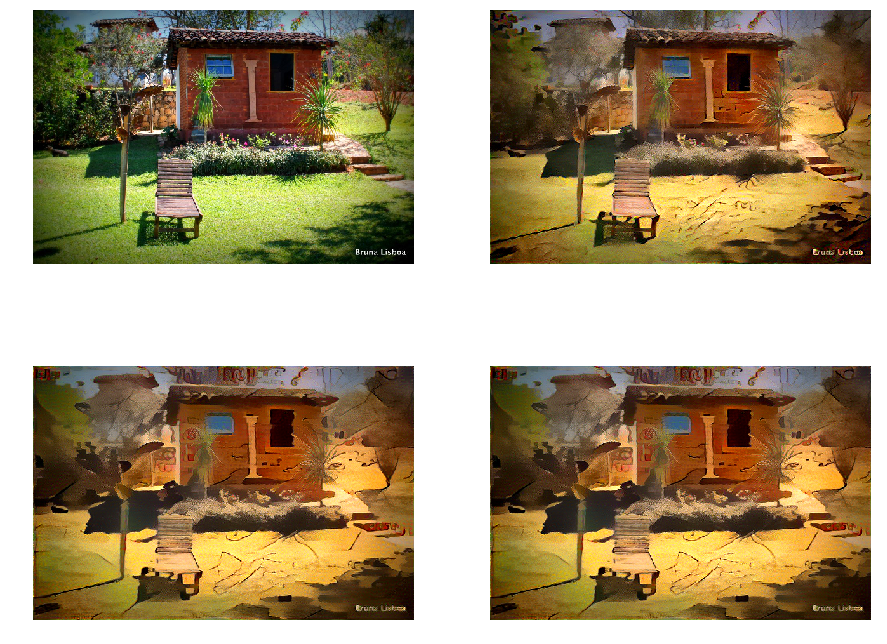

In [24]:
fig = plot.figure(figsize=(15, 12))

plot.subplot(2, 2, 1)
plot.imshow(deprocess_image(vgg_image))
plot.axis('off')

plot.subplot(2, 2, 2)
plot.imshow(deprocess_image(Q3))
plot.axis('off');

plot.subplot(2, 2, 3)
plot.imshow(deprocess_image(Q2))
plot.axis('off');

plot.subplot(2, 2, 4)
plot.imshow(deprocess_image(Q1))
plot.axis('off');